In [65]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from sklearn.exceptions import ConvergenceWarning

import warnings
import sys
import os

# Load Data

In [44]:
X_train = pd.read_pickle('./datasets/heart_disease/X_train_scaled.pkl')
y_train = pd.read_pickle('./datasets/heart_disease/y_train_scaled.pkl')
X_test = pd.read_pickle('./datasets/heart_disease/X_test_scaled.pkl')
y_test = pd.read_pickle('./datasets/heart_disease/y_test_scaled.pkl')

In [45]:
X_train.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope
378,1.753540,1,2,0.403985,-1.850065,1.894070,0,0.793140,1,1.055374,1
356,-0.817871,1,2,-0.950506,-1.850065,-0.527964,0,-0.924506,1,0.577847,1
738,1.217829,0,1,1.487578,1.498941,-0.527964,2,0.558916,0,-0.090691,0
85,1.324972,1,2,0.403985,-0.556976,-0.527964,0,-1.666216,1,0.100320,1
427,0.574977,1,2,0.403985,-1.850065,-0.527964,1,-0.768356,1,0.100320,1


# Train MLP

### Baseline

Validation Accuracy: 0.902
Test Accuracy: 0.859
F1 Score: 0.880


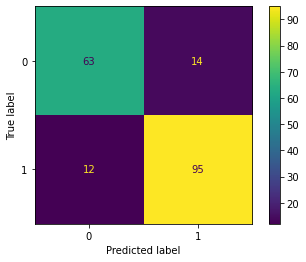

In [39]:
# Baseline model
clf = MLPClassifier(random_state=0).fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Print accuracy
print(f'Validation Accuracy: {clf.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.3f}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()

# Grid Search

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Runtime:11.304670572280884
Best Score: 0.885
Best Parameters
{'activation': 'relu', 'hidden_layer_sizes': 40, 'max_iter': 200, 'solver': 'adam'}
Validation Accuracy: 0.904
Test Accuracy: 0.885
F1 Score: 0.885


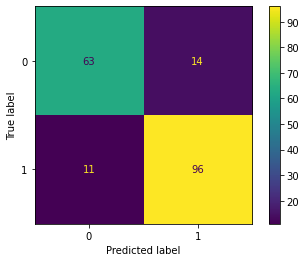

In [41]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

#sizes = [(i, i) for i in range(25, 201, 25)] + \
#        [(i, i, i) for i in range(25, 201, 25)]

sizes = [i for i in range(5, 201, 5)]

parameters = {
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    #'alpha': [0.0001, 0.001],
    #'learning_rate': ['constant', 'invscaling', 'adaptive'],
    #'learning_rate_init': [0.001, 0.01, 0.1],
    'hidden_layer_sizes': sizes,
    'max_iter': [200],
}

mlp = MLPClassifier(random_state=0)

start_time = time.time()

clf = GridSearchCV(estimator=mlp, 
                   param_grid=parameters, 
                   scoring='f1',
                   verbose=1,
                   n_jobs=-1).fit(X_train, y_train)

df = pd.DataFrame(clf.cv_results_)
df.tail()
df.to_csv('./results/hd/results_hd_mlp.csv', index=False)

print(f'Runtime:{time.time() - start_time}')
print(f'Best Score: {clf.best_score_:.3f}')
print('Best Parameters')
print(clf.best_params_)

y_pred = clf.predict(X_test)

# Print accuracy
print(f'Validation Accuracy: {clf.score(X_train, y_train):.3f}')
print(f'Test Accuracy: {clf.score(X_test, y_test):.3f}')
print(f'F1 Score: {f1_score(y_test, y_pred):.3f}')

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)

disp.plot()
plt.show()

# Final Graphs

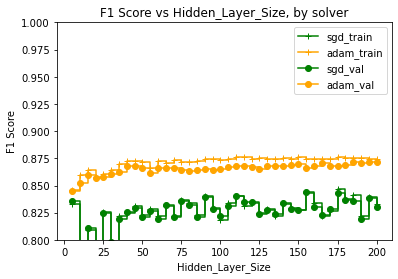

In [51]:
x_scale = [i for i in range(5, 201, 5)]
sizes = [i for i in range(5, 201, 5)]

sgd_train = []
sgd_val = []
adam_train = []
adam_val = []

for size in sizes:
    scores = cross_validate(estimator=MLPClassifier(solver='sgd',
                                                    activation='relu',
                                                    hidden_layer_sizes=size,
                                                    max_iter=200,
                                                    random_state=0),
                            X=X_train, 
                            y=y_train,
                            scoring='f1',
                            return_train_score=True,
                            return_estimator=True,
                            n_jobs=-1)

    # Append scores
    sgd_train.append(scores['train_score'].mean())
    sgd_val.append(scores['test_score'].mean())
    
    scores = cross_validate(estimator=MLPClassifier(solver='adam',
                                                    activation='relu',
                                                    hidden_layer_sizes=size,
                                                    max_iter=200,
                                                    random_state=0),
                            X=X_train, 
                            y=y_train,
                            scoring='f1',
                            return_train_score=True,
                            return_estimator=True,
                            n_jobs=-1)

    # Append scores
    adam_train.append(scores['train_score'].mean())
    adam_val.append(scores['test_score'].mean())

    
# Plot Scores
fig, ax = plt.subplots()
ax.set_xlabel('Hidden_Layer_Size')
ax.set_ylabel('F1 Score')
ax.set_title(f'F1 Score vs Hidden_Layer_Size, by solver')

#Training
ax.plot(x_scale, sgd_train, marker="+", label="sgd_train", c='green', drawstyle="steps-post")
ax.plot(x_scale, adam_train, marker="+", label="adam_train", c='orange', drawstyle="steps-post")

# Validation
ax.plot(x_scale, sgd_val, marker="o", label="sgd_val", c='green', drawstyle="steps-post")
ax.plot(x_scale, adam_val, marker="o", label="adam_val", c='orange', drawstyle="steps-post")

ax.set_ylim([0.8, 1.0])

ax.legend()
plt.show()

# Loss Curve

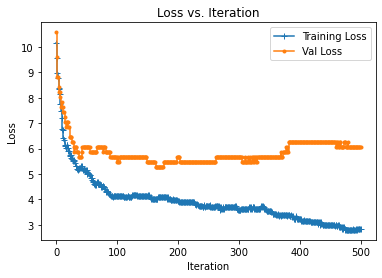

In [89]:
mlp = MLPClassifier(activation="relu",
                    solver='adam',
                    hidden_layer_sizes=40,
                    max_iter=1, 
                    warm_start=True,
                    random_state=0)

training_loss = []
val_loss = []

x_axis = [i for i in range(500)]    
    
for i in x_axis:
    mlp.fit(X_train, y_train)
    training_loss.append(log_loss(y_train, mlp.predict(X_train)))
    val_loss.append(log_loss(y_test, mlp.predict(X_test)))

# Plot Loss
fig, ax = plt.subplots()
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title(f'Loss vs. Iteration')

#Training
ax.plot(x_axis, training_loss, marker="+", label="Training Loss", drawstyle="steps-post")

# Validation
ax.plot(x_axis, val_loss, marker=".", label="Val Loss", drawstyle="steps-post")

ax.legend()
plt.show()